In [16]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs
!ls german-traffic-sign   
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2
 
 
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
 
%matplotlib inline
np.random.seed(0)
# TODO: Implement load the data here.
with open('german-traffic-signs/train.p', 'rb') as f:     #Opening training data, 'rb' read in binary format, then store it in the variable f 
    train_data = pickle.load(f)                           #Unpickeling the data stored in f and storing it in the train_data so we can use it
with open('german-traffic-signs/valid.p', 'rb') as f:     #Opening validation data, 'rb' read in binary format, then store it in the variable f 
    val_data = pickle.load(f)                             #Unpickeling the data stored in f and storing it in the validation_data so we can use it
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as f:      #Opening test data, 'rb' read in binary format, then store it in the variable f 
    test_data = pickle.load(f)                            #Unpickeling the data stored in f and storing it in the test_data so we can use it
 
#These unpickeled datasets are dictionaries with key value pairs. We are interested in two values, viz features and labels

# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']       #features: Values of training images in pixel representation, label: labels each training image to its belonging class.
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
 
#already 4 dimensional
print(X_train.shape)      # print format is : Number of images, Dimension x, Dimension y, Depth
print(X_test.shape)
print(X_val.shape)

# STOP: Do not change the tests below. Your implementation should pass these tests.
# Checking two conditions, 1. No. of images = No. of labels or not, 2. Dimensions = 32 x 32 x 3 or not
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.
ls: cannot access 'german-traffic-sign': No such file or directory
(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


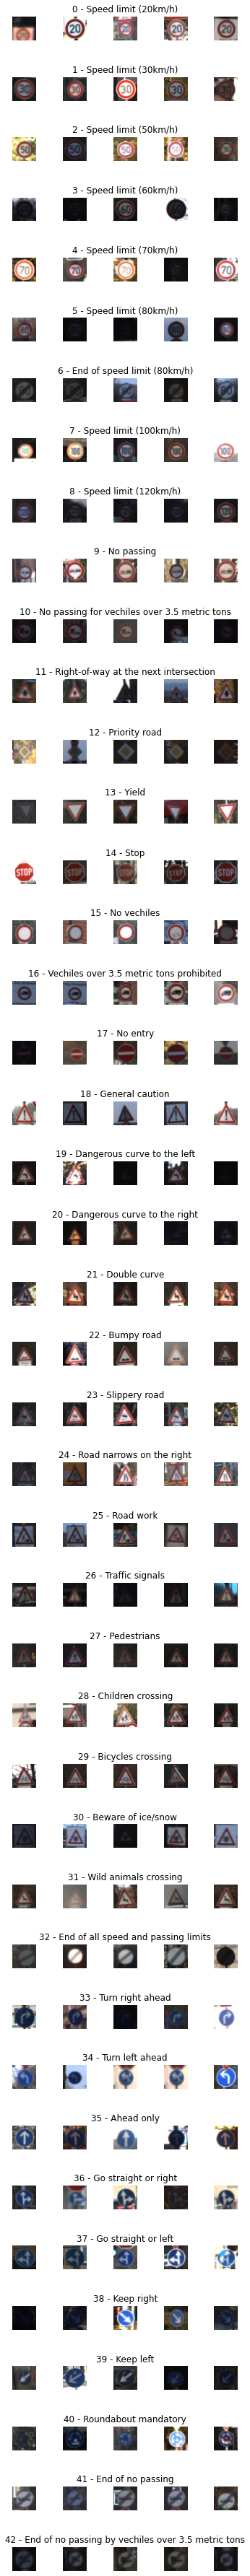

In [17]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
  
num_of_samples=[]
 
cols = 5            # Grid of 5 columns
num_classes = 43    # As there are 43 total classes
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))    #Rows = classes = 43, Columns = cols = 5, figsize(width, height)
fig.tight_layout()      # To prevent overlapping of plots due to inappropriate packing
 
for i in range(cols):                      # Outer for loop for columns
  for j, row in data.iterrows():           # For each column, we are iterating through every row
    x_selected = X_train[y_train == j]     # Out of all the data present in X_train, only keep the data of the j or current row
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))    # Out of all x_selected images on previos step, we select one image randomly and place it in the current grid, also changing the color map to gray scale
    axs[j][i].axis("off")                  # Turning off all the axis 
    if i == 2:                             # If we reach the column 2 (the middle one)
      axs[j][i].set_title(str(j) + " - " + row["SignName"])   #Set the title to j (1,2,3,4,......43) + Name of the sign class
      num_of_samples.append(len(x_selected))    # For finding out total number of images belonging to each class

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


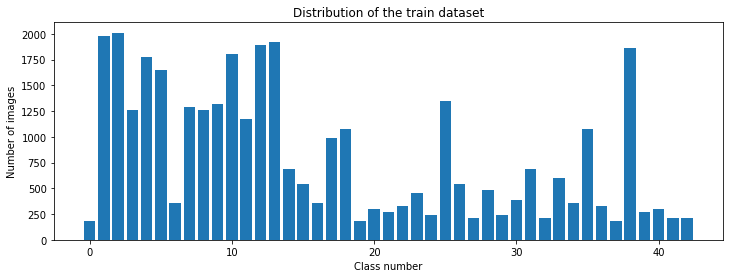

In [18]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)  # Plotting all the class distributions
#plt.bar()
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36
(32, 32)


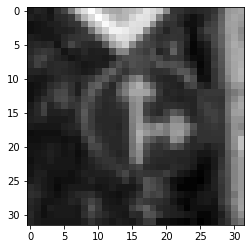

In [19]:
import cv2

print(X_train[1000].shape)
print(y_train[1000])         #printing label of our image
def grayscale(img):          #Converting RGB image in Gray scale image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # 1: image, 2: Type of conversion that is required: In our case BGR to Gray
    return img

img = grayscale(X_train[1000])
plt.imshow(img, cmap=plt.get_cmap("gray"))    
print(img.shape)

(32, 32)
(32, 32)


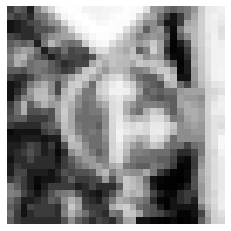

In [20]:
img = grayscale(X_train[1000])    # loading the grayscale image
plt.imshow(img)
plt.axis("off")
print(img.shape)
def equalize(img):
    img = cv2.equalizeHist(img)     #This function will only accept a gray scale image
    return img
img = equalize(img)
plt.imshow(img, cmap=plt.get_cmap("gray"))
plt.axis("off")
print(img.shape)

(34799, 32, 32)


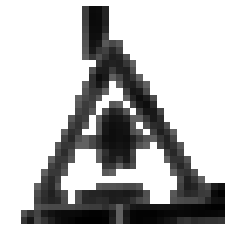

In [21]:
def preprocess(img):      #We will use this function to preprocess our entire dataset  
    img = grayscale(img)
    img = equalize(img)
    img = img/255         # Normalization: This will normalize all the pixel values betwenn 0 and 1
    return img            # Returning fully preprocessed image

# Now we will run our dataset through the preprocessing function
# map function : What that will do is iterate through the entire array and for every element of the array 
# that it loops through it returns a new element based on the specified function is that allocated for each item in the array.
# Ultimately creating a new array with updated values 

X_train = np.array(list(map(preprocess, X_train)))  # list function to store the return values and finally formatting it as array so we can store it in our X_train variable
X_val = np.array(list(map(preprocess, X_val)))
X_test = np.array(list(map(preprocess, X_test)))

plt.imshow(X_train[random.randint(0, len(X_train) - 1)], cmap=plt.get_cmap("gray"))
plt.axis('off')
print(X_train.shape)

In [22]:
X_train = X_train.reshape(34799, 32, 32, 1)  # Reshaping the training dataset by adding a depth of 1 to it
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
print(X_train.shape)
print(X_train.shape)
print(X_train.shape)

(34799, 32, 32, 1)
(34799, 32, 32, 1)
(34799, 32, 32, 1)


(15, 32, 32, 1)


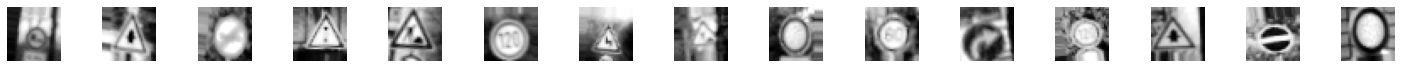

In [23]:
#Adding Data Augmentation

"""
ImageDataGenerator: This class will allow us to define the types of transformations we want to make to our 
                    data sets and it will also allow us to set range limits for adjusting how extreme these transformations 
                    can get.

"""

from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,     # This implies the maximm horizontal shift possible is 10% of the original image  (If it is greater than 1, it will consider them as shifting by the amount of pixels)
                            height_shift_range=0.1,     # Similar  to above, Just this is the Vertical shift 
                            zoom_range=0.2,             # Degree of zoom (0.8 to 1.2)
                            shear_range=0.1,            # With respect to x and y axis
                            rotation_range=10)          # Rotates the image by assigned degree

# We can now fit this image data generator to our actual training data set

datagen.fit(X_train)

"""
datagen.fit() : The interesting thing to note about the image data generator is that it's an iterator 
                which only returns batches of transformed images when requested. This means that the 
                data generator does not perform operations on all the images in our data sets as that
                would be very memory intensive, due to all the new images being created. 
                Instead it only creates these new augmented images in real time what are requested.
                This reduces overall memory requirements. However it leads to additional time cost during 
                the training process as that is when the data will be created. 
"""

# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15)   # Flow is requesting image generator for images || 1 and 2 Dataset and Labels, 3.batch size: It referes to the amount of images created every time this data flow that iterator is called. 
X_batch, y_batch = next(batches)

"""
next() : We need to take our batch iterator containing data about our newly created images and store this
data inside of an X_batch and respective y_batch array.
This is done using the built in Python command next. And the next function simply calls an iterator item
and retrieves the next item for it.

As we defined our iterator to create a batch size of 15, we get 15 new images each time the next() function
is called on the iterator.
"""

fig, axs = plt.subplots(1, 15, figsize=(20, 5))   #1. No of Rows, 2. No. of columns, 3. Figure size 
fig.tight_layout()       # Ensuring that the figures dont overlap
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32), cmap=plt.get_cmap("gray"))    #Reshaping and converting each image to gray scale
    axs[i].axis("off")
 
print(X_batch.shape)    # Printing the total batch shape

•	The first line shows the number of augmented images which is 15, then the dimensions and depths of the augmented images which are 32 x 32 and 1, respectively.
•	And running this code displays our brand new 15 images that our image generator created.
•	For better visualization I have shown only four images out of 15.
•	They have been augmented in different ways to help add variety to our datasets.
•	As we can see these images do not look like our typical traffic sign dataset images.
•	Some have been zoomed in or out while others have been rotated sheared or shifted.
•	For the most part many of these images have been transformed in more than one way.
•	This means that our data augmentation process was indeed effective and will be a useful training tool for our model.

In [0]:
# The to_categorical will take in two arguments the first being our labeled data
# that needs to be one hot encoded and the second is the total amount of classes 
# within our dataset which in our case is 43, and then returns the one hot encoded 
# labels which we want for proceeding further.

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)
# create model
"""
Convolutional Layer: The image is first processed in the convolutional layer where the convolved images that clearly detect specific 
                     features from the image are then operated on by the relu activation function to produce the final output

Pooling:             The images are then scaled into an abstracted form of the original feature map preserving the general pattern.
                     Pooling operation scales down the feature map and reduces its dimensionality so as to prevent overfitting yet 
                     still retain all of the important information such that the features are invariant to small translations distortions 
                     and so on (X example). 

Relu:                Used to add non linearity. The reason being any kind of neural network must contain nonlinearity since most of the real world data
                     that the neural network is required to learn is non-linear. It converts all the negative pixel values in the feature map to zeros.
                     The reason behind selection of Relu function is the other activation functions like sigmoid or tan H are prdisposed to a common 
                     artificial neural network problem called the vanishing gradient problem. At a very basic level, this problem refers to a decreased 
                     feedforward gradient within the deep neural network.
                     Deep neural networks rely on gradient descent and back propagation techniques to adjust their weight parameters. This is essentially 
                     how they learn. However if the gradient in the network gets too small or effectively vanishes then the network is unable to make use 
                     of gradient descent in an efficient way, and learning slows down significantly. If the gradient is small, the network can only adjust 
                     weight parameters by a very small amount with each update which means the network learns very slowly.
                     This problem affects the sigmoid function because the sigmoid function has a relatively low gradient, as it levels at extreme values of 
                     infinity and negative infinity. The low gradient becomes an issue as within a neural network the gradient value is fed forward through 
                     the network and multiplied with additional gradient values. If the sigmoid activation function is used then all these gradient values are
                     limited between the range of 0 and point to some small value (e.g. 0.5). As we are now multiplying many decimals together creates a smaller
                     and smaller number. Therefore as the network feeds forward the gradient in the network seems to vanish to a very low number.
                     This issue can be fixed by using the rectified linear unit.The relu activation function. The relu function returns a value of 0 if the input 
                     is negative. However, if the input is positive then the output that returned is just the same value. The key thing to notice though is that 
                     the gradient value of the relu function is either 0 or it is 1. 
                     In the case of a gradient of 1, We know that the vanishing gradient problem cannot occur as multiplying by 1 does not cause the gradient 
                     values to decrease. 

"""
 
def modified_leNet_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))   # 1: No of filters, 2. Size of filters, 3 Inout shape (Only required for first layer) 
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))             # Pooling size : (2,2) will scale down the original image to its half size : Ised to reduce overfitting 
  #model.add(Dropout(0.5))

  model.add(Flatten())        # Simply flattens our dataset so we can pass it to fully connected layer (Converts it to 1-D array form)
  model.add(Dense(500, activation='relu'))    # This is fully connected layerr.  1: Number of nodes (Lower number provides low accuracy and higher number provides more accuracy but requires more computational power)
  model.add(Dropout(0.5))     # 1. Fraction of nodes to be dropped, used to reduce overfitting
  model.add(Dense(43, activation='softmax'))    # As number of classes are 43
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])    # 1. learning rate 2. Loss: as our network is categorizing a multiclass dataset, 3 Metrics:  As we re interested in accuracy, we are only using accuracy metric
  return model


In [25]:

model = modified_leNet_model()
print(model.summary())    # Gives summary of model

# Now lets train our model and evaluate its performance
# Notice the use of fit_generator 
"""
  We are going to use the model.fit_generator() statements, which is capable of running our image generator
  in parallel with the model training process.
  The statement will train our model using the augmented data produced by our generator.
  Also notice the use of datagen.flow() statement.
"""
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),        # 1. Training Data set, 2 Training Data Labels
                            steps_per_epoch=2000,
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)            # Shuffle = 1 to ensure that the proper shuffling takes place. 


"""
Considering that our traffic signs that has 43 classes to classify, we will need a larger pool of images to train on, 
for effective training.
So let's try this with a dataset of 100,000 images. And for a batch size of 50, we will need a step size of 2000.
2000 batches times 50 images per batch to get a total of 100,000 images per epoch. 

(2000 batches * 50 images/batch = 100,000 images/epoch)
"""

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 480)              

"\nConsidering that our traffic signs that has 43 classes to classify, we will need a larger pool of images to train on, \nfor effective training.\nSo let's try this with a dataset of 100,000 images. And for a batch size of 50, we will need a step size of 2000.\n2000 batches times 50 images per batch to get a total of 100,000 images per epoch. \n\n(2000 batches * 50 images/batch = 100,000 images/epoch)\n"

Text(0.5, 0, 'epoch')

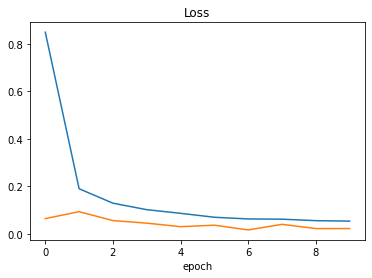

In [31]:
# Plotting loss and accuracy graphs and Evaluating model performance

plt.plot(history.history['loss'])     
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
 


Text(0.5, 0, 'epoch')

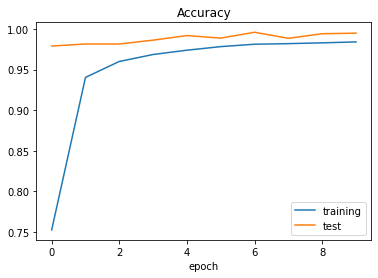

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
 

Test score: 0.09193965421665005
Test accuracy: 0.9804434180259705
(32, 32)
predicted sign: [13]


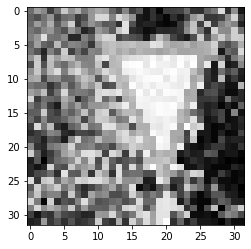

In [45]:
# TODO: Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#predict internet traffic signs
import requests
from PIL import Image   
#url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
#url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
#url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
#url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'

r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
print("predicted sign: "+ str(model.predict_classes(img)))


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


np.random.seed(0)
points = 500
X = np.linspace(-3, 3, points)
y = np.sin(X) + np.random.uniform(-0.5, 0.5, points)
model = Sequential()
model.add(Dense(50, activation='sigmoid', input_dim=1))
model.add(Dense(30, activation='sigmoid'))
model.add(Dense(1))


adam = Adam(lr=0.01)
model.compile(loss='mse', optimizer=adam)
model.fit(X, y, epochs=50)
predictions = model.predict(X)
plt.scatter(X, y)
plt.plot(X, predictions, 'ro')
plt.show()